In [652]:
] activate ../../Acceleration

 Activating environment at `~/Desktop/Code/Acceleration/Acceleration/Project.toml`


In [762]:
using Acceleration
using LinearAlgebra

n = 2000; # number of samples
d = 70;    # number of features
selected_labels = [0,2];  ## Only two labels allowed

data, labels = load_dataset("FashionMNIST",[0,1],n,d);
f,∇f,∇ϕ_cjg,σ,L,μ  = linear_regression(data,labels);
μ2 = μ

┌ Info: Loading dataset FashionMNIST with 60000 samples and 784 features
└ @ Acceleration /Users/victor/Desktop/Code/Acceleration/Acceleration/src/datasets.jl:26


16.65727426328816

In [763]:
n = size(data,2)
x_ini = zeros(n)


using JuMP
using Ipopt

@time model = Model(with_optimizer(Ipopt.Optimizer))
@time set_silent(model)
@time @variable(model, x[1:n])
@time @objective(model, Min, f(x))
@time optimize!(model)
@time x_opt = value.(x);

  0.000188 seconds (652 allocations: 36.172 KiB)
  0.000004 seconds
  0.033982 seconds (63.98 k allocations: 3.318 MiB)
  0.302447 seconds (50.75 k allocations: 198.334 MiB)
  0.002008 seconds (1.03 k allocations: 273.688 KiB)
  0.000050 seconds (843 allocations: 17.094 KiB)


In [795]:
n = length(x_ini)
x = x_ini;
y = zeros(n);
z = zeros(n);
v = zeros(n);
A = 1;
AX = zeros(n);

k = 1000;
yks = zeros(n,k);
zks = zeros(n,k);
up = zeros(k);
#μ = 0;
s = zeros(n);
noise = 0;
α = 1;
accu_noise = 0;
low = 0;
high = 0;

for i=1:k   
   
    a = (L-μ); b = -(2*μ*A+σ); c = -μ*A^2 - σ*A;
    α = (-b + sqrt(b^2 - 4*a*c)) / (2*a);
    A = A + α;
    
    x = inv(A/α - μ*α/(μ*A+σ)) * ((A-α)/α *y + (μ*(A-α)+σ)/(μ*A + σ) * v);
    AX = AX + α*x;
    
    η = inv(3*α)*(z-s-α*∇f(x));
    #η = -∇f(x) + sign.(∇f(x)) .* (abs.(∇f(x)) .> norm(∇f(x),Inf)/2) .* norm(∇f(x),Inf)/2;
    #η = -∇f(x) + sign.(∇f(x)) .* norm(∇f(x))/d;
    #η = - ∇f(x) + sign.(∇f(x)) 
    η = zeros(n)
    #η = -∇f(x) + 0.5*∇f(x);
    
    
    approx_gradient = ∇f(x)+η;
    
    #println(norm(η)/norm(approx_gradient) <= 1)
    
    s = s + α*η;
    z = z - α*approx_gradient;
    
    noise = α*η'*(s-z) + α^2*(norm(approx_gradient,2)^2 - approx_gradient'*∇f(x) + 0.5*norm(η,2)^2);
    accu_noise = accu_noise + noise;
    
    v_past = v;
    v = (z + μ*AX)*inv(1 + μ*A);
    y = (A-α)*inv(A)*y + α*inv(A)*v; 
    
    term = v - (μ*(A-α) + σ)/(μ*A + σ)*v_past - (μ*α)/(μ*A + σ) * x
    #println(μ * A / α^2 * norm(term,2)^2)
    #println(norm(term,2)^2)
    println(sqrt(A^2 / α^2 * norm(term,2)^2))
    
    up[i] = (1/A) * (0.5*norm(x_opt,2)^2 + max(accu_noise,0))
    yks[:,i] = y;
    zks[:,i] = z;

end

x_out = yks;
x_gd = gradient_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd = accelerated_mirror_descent(f,∇f,∇ϕ_cjg,x_ini,σ,L,k);
x_amd2 = SCVX_AMD(f,∇f,∇ϕ_cjg,x_ini,σ,L,μ2,k);

71.42062275605876
57.360475136801625
39.39280364316506
20.253418741883284
6.028579455992098
17.130876937612555
29.263909205050584
37.11004123091441
40.22808143779628
38.88542590289155
33.80043368962466
25.99204676310209
16.64623920960183
7.102080988618774
3.6723942568752608
10.617448807051131
16.136800999029823
19.366174370077424
20.243288271756214
18.99245679263396
16.043003983586175
11.971721759580022
7.502122679739167
3.9386145318294905
4.373768712806512
7.067770393371177
9.250689477825764
10.38607680226056
10.419723763746239
9.477078792613474
7.792778616584629
5.680657267390035
3.5645526630663125
2.27975023916339
2.8085168146526263
3.978120095364267
4.852763223326662
5.21727116036544
5.061454560185409
4.463895283458418
3.5599831832204005
2.539239808198458
1.70494552099766
1.5428676745332635
2.015858617401803
2.5657791122346314
2.9383273119966447
3.071231266227236
2.9780249418555105
2.714715757856667
2.3671750981185724
2.0416320808925574
1.8403634110533549
1.804607076859424
1.879330

2.138195697979768e-5
2.0909851894996883e-5
2.0440299158068774e-5
1.9974539416945487e-5
1.9513810516917997e-5
1.9059334302659192e-5
1.8612303807309738e-5
1.8173870568750894e-5
1.774513230252149e-5
1.7327120861218825e-5
1.6920790693435826e-5
1.6527007715777747e-5
1.6146539012315997e-5
1.578004321156536e-5
1.5428062008500184e-5
1.5091012867613962e-5
1.4769183138271958e-5
1.4462725898225631e-5
1.4171657535624912e-5
1.3895857463406409e-5
1.3635069853883739e-5
1.3388907672730462e-5
1.3156858853449162e-5
1.2938294582799045e-5
1.2732479631752525e-5
1.253858428206447e-5
1.235569788493899e-5
1.2182843339421791e-5
1.2018992482539851e-5
1.1863081752298063e-5
1.1714027881810274e-5
1.157074326855622e-5
1.1432150677812021e-5
1.1297197082656583e-5
1.1164866334824518e-5
1.1034190644619525e-5
1.0904260644917653e-5
1.0774234049876657e-5
1.0643342873670089e-5
1.0510899166797186e-5
1.0376299425066886e-5
1.0239027577870129e-5
1.009865672768249e-5
9.954849699367333e-6
9.807358414271496e-6
9.656022326530104e-

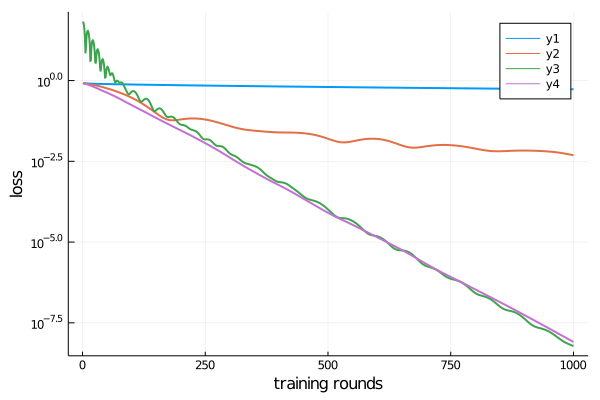

In [796]:
using Plots
using LinearAlgebra

p_out = sqrt.(sum((x_out .- x_opt).^2, dims=1)');
p_gd = sqrt.(sum((x_gd .- x_opt).^2, dims=1)');
p_amd = sqrt.(sum((x_amd .- x_opt).^2, dims=1)');
p_amd2 = sqrt.(sum((x_amd2 .- x_opt).^2, dims=1)');

plot(max.(hcat(p_gd,p_amd,p_amd2,p_out),1e-20),yaxis=:log,linewidth=2,xlabel="training rounds",ylabel="loss")

In [671]:
A

NaN

In [580]:
accu_noise/A

0.5199852121415898

In [581]:
accu_noise

1.9515052801398863e18

In [582]:
low / (low + high)

0.4075

In [583]:
high / (low + high)

0.5925

In [593]:
L

48524.78980734217

In [716]:
σ

1

In [597]:
μ

203.67793843050276